In [4]:
from catinous.dataset import BatchDataset, ContinuousDataset
from catinous.dynamicmemory.DynamicMemoryModel import DynamicMemoryModel 
import catinous.dynamicmemory.DynamicMemoryModel as dmodel
import catinous.utils as cutils
import os
import pandas as pd
from py_jotools import mut, slurm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
#import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from catinous.dataset.ContinuousDataset import *
from catinous.dataset.BatchDataset import *
from torch.utils.data import DataLoader


In [5]:
def ap_model_seeds(hparams, seed=2314134, split='test'):
    recalls = {'ges': [], 'geb': [], 'sie': []}
    precision = {'ges': [], 'geb': [], 'sie': []}
    
    hparams['seed'] = seed

    model, logs, df_mem, expname = lungmodel.trained_model(hparams, train=False)
    model.eval()

    for res in ['ges', 'geb', 'sie']:
        ds_test = LIDCDataset('/project/catinous/lunadata/luna_lunacombined_dataset_malignancy.csv', 
                      cropped_to=(288, 288), split=[split], res=res, validation=True)

        device = torch.device('cuda')
        iou_thres = 0.5

        overall_true_pos = dict()
        overall_false_pos = dict()
        overall_false_neg = dict()
        overall_boxes_count = dict()
        for k in np.arange(0.0, 1.01, 0.05):
            overall_true_pos[k] = 0
            overall_false_pos[k] = 0
            overall_false_neg[k] = 0
            overall_boxes_count[k] = 0
            

        for batch in ds_test:
            img_batch, annot, res, image = batch
            img_batch = img_batch.to(device)

            out = model.model(img_batch)
            out_boxes = [cutils.filter_boxes_area(out[i]['boxes'].cpu().detach().numpy(), out[i]['scores'].cpu().detach().numpy()) for i in range(len(out))]
            boxes_np = [b[0] for b in out_boxes]
            scores_np = [b[1] for b in out_boxes]

            final_boxes, final_scores = cutils.correct_boxes(boxes_np, scores_np)

            gt = annot['boxes'][0]
            for k in np.arange(0.0, 1.01, 0.05):
                false_positives = 0
                false_negatives = 0
                true_positives = 0
                detected = False
                boxes_count = 0
                if len(final_boxes)>0:
                    for i, b in enumerate(final_boxes):
                        if final_scores[i]>k:
                            boxes_count += 1
                            if cutils.bb_intersection_over_union(gt, b)>iou_thres:
                                detected = True
                            else:
                                false_positives += 1
                    if detected:
                        true_positives += 1
                    else:
                        false_negatives += 1
                overall_true_pos[k] += true_positives
                overall_false_pos[k] += false_positives
                overall_false_neg[k] += false_negatives
                overall_boxes_count[k] += boxes_count
        for k in np.arange(0.0, 1.01, 0.05):
            if (overall_false_neg[k]+overall_true_pos[k])==0:
                recalls[res].append(0.0)
            else:
                recalls[res].append(overall_true_pos[k]/(overall_false_neg[k]+overall_true_pos[k]))
            if (overall_false_pos[k]+overall_true_pos[k])==0:
                precision[res].append(0.0)
            else:
                precision[res].append(overall_true_pos[k]/(overall_false_pos[k]+overall_true_pos[k]))
    return recalls, precision

def get_ap_for_res(hparams, seed=2314134, split='test'):
    recalls, precision = ap_model_seeds(hparams, seed, split)
    
    aps = dict()
    for res in ['ges', 'geb', 'sie']:
        prec = np.array(precisions[res])
        rec = np.array(recalls[res])
        ap = []
        for t in np.arange(0.0, 1.01, 0.1):
            prec_arr = prec[rec>t]
            if len(prec_arr)==0:
                ap.append(0.0)
            else:
                ap.append(prec_arr.max())
        aps[res] = np.array(ap).mean()
    return aps

In [6]:
hparams = {
    'continuous': False,
    'datasetfile': '/project/catinous/lungnodulesfinal.csv',
    'batch_size': 8,
    'training_batch_size': 8,
    'task': 'lidc',
    'model': 'rnn',
    'scanner': None,
     'noncontinuous_steps': 1000,
    'scanner': 'geb', 
    'noncontinuous_train_splits': ['base', 'train'],
    'order': ['ges', 'geb', 'sie', 'time_siemens'],
    'use_memory': False
}

model, _, _, _ = dmodel.trained_model(hparams)

Read: /project/catinous/trained_models/lidc_batch_lungnodulesfinal_base-train_1_283032ea6c.pt


In [43]:
dl_val = DataLoader(LIDCBatch('/project/catinous/lungnodulesfinal.csv',
                                      split='val', res='sie', validation=True),
                      batch_size=8,
                      num_workers=2,
                      collate_fn=cutils.collate_fn)

In [44]:
device = torch.device('cuda')
model.model.to(device)
model.eval()

for batch in dl_val:
    x, y, scanner, filepath = batch
    x = list(i.to(device) for i in x)
    #targets = [{k: v.to(self.device) for k, v in t.items()} for t in y]
    
    out = model.forward(x)
    break

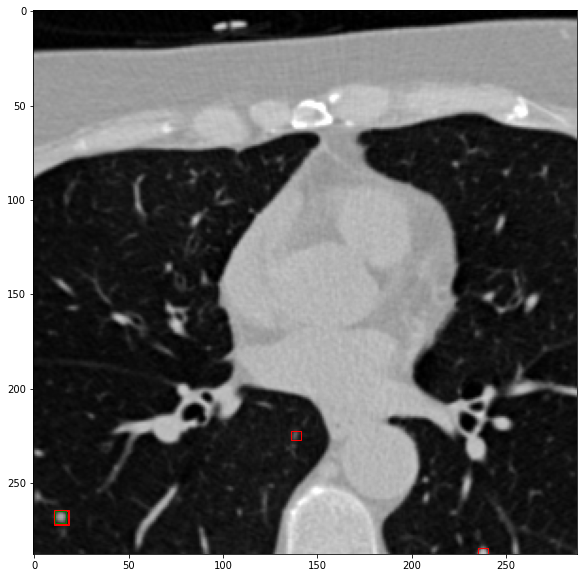

In [46]:
idx = 5

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

xywh = [[ab[0], ab[1], ab[2] - ab[0], ab[3] - ab[1]] for ab in out[idx]['boxes']]

ax.imshow(x[idx].detach().cpu().numpy()[0])
#plt.scatter([x], [y])
for k, xy in enumerate(xywh):
    rect = patches.Rectangle((xy[0],xy[1]),xy[2],xy[3],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
gt = y[idx]['boxes'][0]
rect = patches.Rectangle((gt[0], gt[1]), gt[2] - gt[0], gt[3] - gt[1], edgecolor='g', facecolor='none')
ax.add_patch(rect)

In [33]:
out

[{'boxes': tensor([[7.2256e+00, 1.3150e+02, 1.7345e+01, 1.4098e+02],
          [9.2742e+01, 1.3054e+02, 1.2457e+02, 1.6057e+02],
          [2.8798e+02, 1.9091e-02, 2.8800e+02, 2.5447e+01],
          [2.8797e+02, 7.5509e+01, 2.8800e+02, 8.0808e+01],
          [2.8796e+02, 7.6827e+01, 2.8800e+02, 8.2226e+01],
          [1.0754e+02, 1.1350e+02, 1.1545e+02, 1.2135e+02],
          [2.8797e+02, 7.5494e+01, 2.8800e+02, 8.0801e+01],
          [2.8796e+02, 7.6812e+01, 2.8800e+02, 8.2218e+01],
          [2.8798e+02, 0.0000e+00, 2.8800e+02, 2.5411e+01],
          [7.2447e+00, 1.3108e+02, 1.7145e+01, 1.4080e+02],
          [4.3129e+00, 1.2863e+02, 1.9312e+01, 1.4453e+02],
          [9.8673e+01, 1.3453e+02, 1.1844e+02, 1.5737e+02]], device='cuda:0'),
  'labels': tensor([2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2], device='cuda:0'),
  'scores': tensor([0.7155, 0.5304, 0.2998, 0.2998, 0.2998, 0.2425, 0.2423, 0.2423, 0.2423,
          0.2210, 0.1059, 0.0637], device='cuda:0')},
 {'boxes': tensor([[ 56.5233, 1